# Predicting Daily Stock Price Movement Through Twitter Sentiment Analysis

#### This project evaluates the performance of different sentiment classifers and ML models in terms of predicting whether a company stock will go up or down on a certain day

## 1. Loading Datasets

In [ ]:
# ! pip install -r requirements.txt # download all packages

In [ ]:
import kagglehub
import shutil
import os

# Load stock tweets from kaggle: https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
def download_from_kaggle():
    # Download latest version and save to current directory
    path = kagglehub.dataset_download("equinxx/stock-tweets-for-sentiment-analysis-and-prediction")
    destination = "."
    shutil.copytree(path, destination, dirs_exist_ok=True)

    print("Dataset copied to current directory.")

# download_from_kaggle() # --> dataset already loaded/downloaded 

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset copied to current directory.


In [2]:
import numpy as np
import pandas as pd

tweet_df = pd.read_csv('stock_tweets.csv')
tweet_df['Date'] = tweet_df['Date'].apply(lambda x: x.split(' ')[0]) # include only date, not time
tweet_df['Date'] = pd.to_datetime(tweet_df['Date']) # ensure date column is in datetime format

tweet_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [3]:
# check for any null values
tweet_df.isnull().sum()

Date            0
Tweet           0
Stock Name      0
Company Name    0
dtype: int64

In [ ]:
import yfinance as yf

# Load stock data from yfinance


def create_stock_data():
    # Get the date range for each stock 
    date_ranges = tweet_df.groupby('Stock Name')['Date'].agg(['min', 'max']).reset_index()

    #Fetch stock data using yfinance
    all_data = []

    for i, row in date_ranges.iterrows():
        ticker = row['Stock Name']
        start_date = row['min']
        end_date = row['max']

        # Fetch stock data
        # stock_data = yf.download(ticker, period='60d', interval='1d')
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
        
        # Add ticker column
        stock_data['Ticker'] = ticker 

        stock_data.columns = stock_data.columns.get_level_values(0)

        # Calculate if price went up or down that day (1 for up, 0 for down)  
        stock_data['DailyMovement'] = stock_data.apply(lambda x: 1 if x['Close'] > x['Open'] else 0, axis=1)

        # # Add to our dataset
        all_data.append(stock_data)

    # Combine all stock data
    stock_df_orig = pd.concat(all_data)
    stock_df_orig = stock_df_orig.reset_index()

    stock_df_orig.dropna(inplace=True) # remove rows with NaN values (due to shifting columns)

    stock_df_orig.to_csv('stock_data.csv', index=False) # Save to CSV

# create_stock_data() 
stock_df = pd.read_csv('stock_data.csv')
stock_df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Date,Close,High,Low,Open,Volume,Ticker,DailyMovement
0,2021-09-30,138.863907,141.690258,138.648004,140.983670,89056700,AAPL,0
1,2021-10-01,139.992477,140.257452,136.518433,139.256450,94639600,AAPL,1
2,2021-10-04,136.547867,139.560681,135.694079,139.119052,98322000,AAPL,0
3,2021-10-05,138.481186,139.590139,136.763788,136.891371,80861100,AAPL,1
4,2021-10-06,139.354584,139.501783,135.792205,136.871718,83221100,AAPL,1


## 2. Sentiment Analysis

#### Analyze the sentiment of each tweet by running them through different pretrained sentiment classifiers

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


# Initialize FinBERT model
finbert_model = "ProsusAI/finbert"
finbert_tokenizer = AutoTokenizer.from_pretrained(finbert_model)
finbert_pipeline = pipeline("text-classification", model=finbert_model, tokenizer=finbert_tokenizer, device=-1, top_k=None)

# Initialize VADER sentiment model
nltk.download('vader_lexicon')
vader_analyzer = SentimentIntensityAnalyzer()

# Initialize emotion analysis model
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", device=-1, top_k=None)

# initialize twitter-roBERTa: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
roberta_model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model)
roberta_pipeline = pipeline("sentiment-analysis", model=roberta_model, tokenizer=roberta_tokenizer, device=-1, top_k=None)



Device set to use cpu
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Navid\AppData\Roaming\nltk_data...
Device set to use cpu
c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Navid\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/e

In [9]:
import re 

def preprocess(text):
    
    # only remove links and @mentions for tweets
    text = re.compile(r"http\S+|www\.\S+").sub(" ", text)
    text = re.compile(r"@\w+").sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip() # remove extra white space
        
    return text


def preprocess_roberta(text): # obtained from huggingface
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [10]:
def get_finbert_sentiment(text):

    try:

        # Get sentiment from FinBERT
        sentiments = finbert_pipeline(text, truncation=True)[0]

        # Create a dictionary with sentiment scores
        sentiment_dict = {}
        for sentiment in sentiments:
            sentiment_dict[f'finbert_{sentiment['label']}'] = sentiment['score']
        
        return sentiment_dict

    except Exception as e:
        print(f"Error analyzing sentiment': {e}")
        return {'finbert_positive': 0.0, 'finbert_negative': 0.0, 'finbert_neutral': 0.0}


def get_emotion(text):
    try:

        
        # Get emotion scores
        emotions = emotion_classifier(text, truncation=True)[0]
        
        # Create a dictionary with emotion scores
        emotion_dict = {}
        for emotion in emotions:
            emotion_dict[emotion['label']] = emotion['score']
        
        return emotion_dict
    except Exception as e:
        print(f"Error analyzing emotions': {e}")
        return {
            'anger': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0,
            'neutral': 1.0, 'sadness': 0.0, 'surprise': 0.0
        }
    
def get_vader_sentiment(text):
    try:
        # Get sentiment from VADER
        sentiment = vader_analyzer.polarity_scores(text)
        
        return {"vader_positive": sentiment["pos"], "vader_negative": sentiment["neg"], "vader_neutral":  sentiment["neu"]}
    except Exception as e:
        print(f"Error analyzing sentiment': {e}")
        return {'vader_positive': 0.0, 'vader_negative': 0.0, 'vader_neutral': 0.0}
    

def get_roberta_sentiment(text):

    try:

        # Get sentiment from FinBERT
        sentiments = roberta_pipeline(text, truncation=True)[0]

        # Create a dictionary with sentiment scores
        sentiment_dict = {}
        for sentiment in sentiments:
            sentiment_dict[f'roberta_{sentiment['label'].lower()}'] = sentiment['score']
        
        return sentiment_dict

    except Exception as e:
        print(f"Error analyzing sentiment': {e}")
        return {'roberta_positive': 0.0, 'roberta_negative': 0.0, 'roberta_neutral': 0.0}
    

In [ ]:
from tqdm import tqdm


def analyze_sentiment_finbert(df):
    # Make a copy of the dataframe
    res_df = df.copy()
    
    # Function to process each row
    def process_row(row):
        tweet = row['Tweet'] # get the tweet
        result = {}

        # Preprocess the tweet
        cleaned_text = preprocess(tweet)
        cleaned_text_roberta = preprocess_roberta(tweet) # roberta has different cleaning function

        
        # Call the functions
        result.update(get_finbert_sentiment(cleaned_text))
        result.update(get_emotion(cleaned_text))
        result.update(get_vader_sentiment(cleaned_text))
        result.update(get_roberta_sentiment(cleaned_text_roberta))
        
        # Update the row with all results
        for key, value in result.items():
            row[key] = value
            
        return row
    
    # Apply with progress bar to visualize the progress 
    tqdm.pandas(desc="Processing rows")
    res_df = res_df.progress_apply(process_row, axis=1)
    
    
    return res_df

def create_sentiment_df():
    df_processed = analyze_sentiment_finbert(tweet_df)
    df_processed.to_csv('tweet_sentiment.csv', index=False)
    print("Sentiment analysis completed and saved to CSV.")

# create_sentiment_df() # --> commented because it takes very long to run (1-2 hours)

Processing rows: 100%|██████████| 80793/80793 [2:02:19<00:00, 11.01it/s]  


Sentiment analysis completed and saved to CSV.


## 3. EDA

#### Perform exploratory data analysis on the stock and tweet datasets

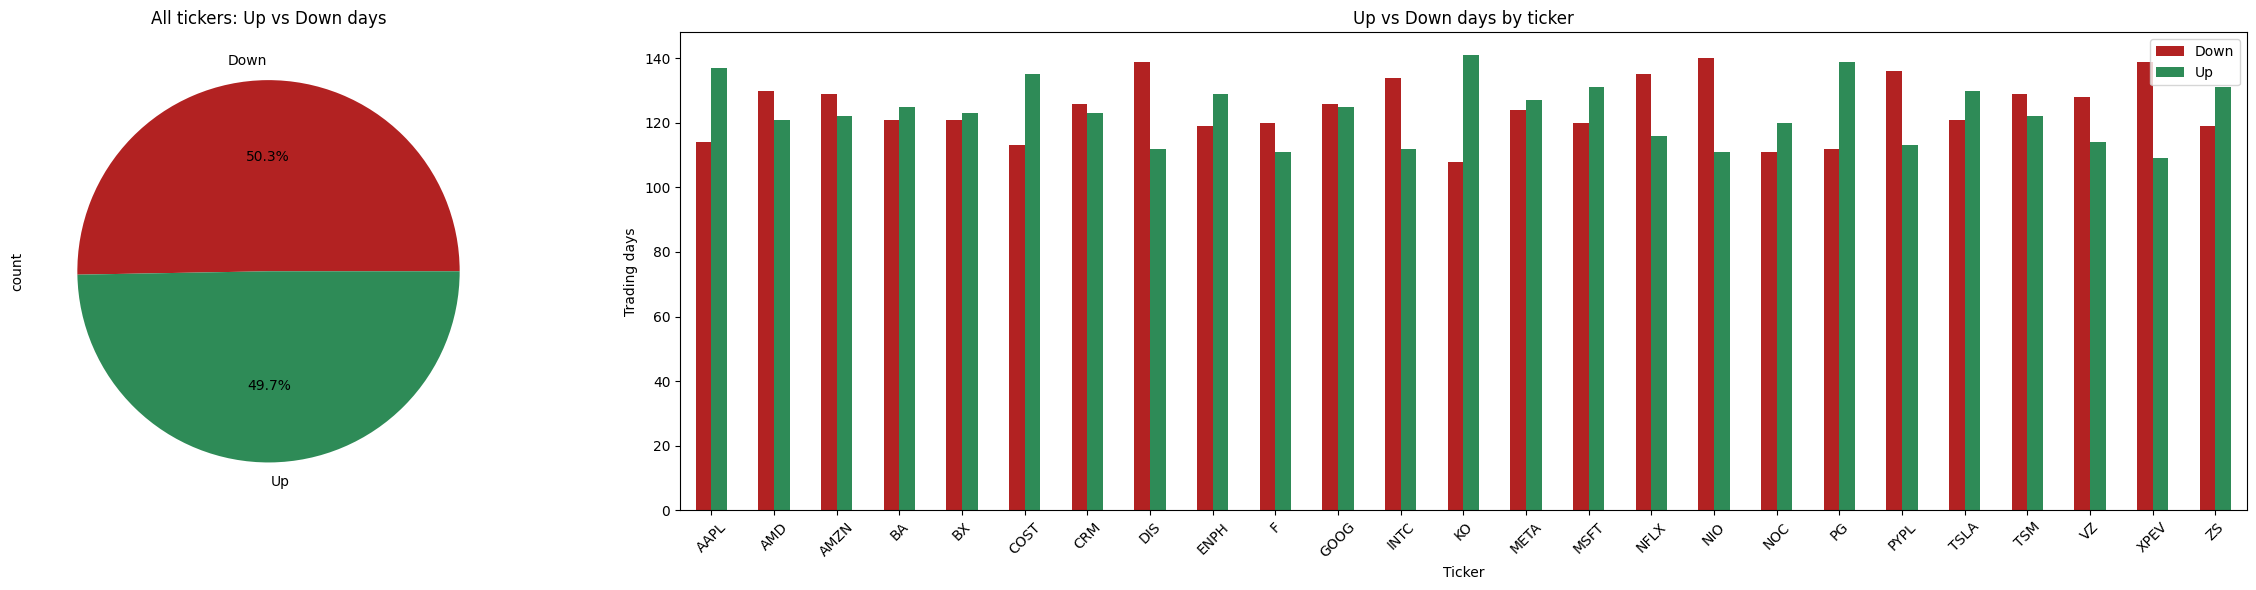

In [13]:
# EDA
import matplotlib.pyplot as plt


# Prepare the data
overall = (stock_df['DailyMovement'].value_counts().rename({0: 'Down', 1: 'Up'}))

per_ticker = (stock_df.groupby(['Ticker', 'DailyMovement']).size().unstack(fill_value=0).rename(columns={0: 'Down', 1: 'Up'}))

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 2]})

# Pie chart
overall.plot(kind='pie',autopct='%1.1f%%', colors=['firebrick', 'seagreen'],ax=axes[0])
axes[0].set_title('All tickers: Up vs Down days')

# Bar chart
per_ticker[['Down', 'Up']].plot(kind='bar',color=['firebrick', 'seagreen'],ax=axes[1])
axes[1].set_title('Up vs Down days by ticker')
axes[1].set_ylabel('Trading days')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='')

plt.tight_layout()
plt.show()

#### The up and down days are split 50/50. However, looking by ticker, some companies are not exactly 50/50 split (examples: KO, COST, INTC, PG, XPEV)

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Helper functions to analyze the sentiment scores (removing softmax and one-hot encoding)

emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
finbert_cols = ['finbert_positive', 'finbert_negative', 'finbert_neutral']
vader_cols = ['vader_positive', 'vader_negative', 'vader_neutral']
roberta_cols = ['roberta_positive', 'roberta_negative', 'roberta_neutral']


def remove_softmax(df):

    col_groups = [finbert_cols, vader_cols, roberta_cols, emotion_cols] # list of lists
    cols = finbert_cols + vader_cols + roberta_cols + emotion_cols # list of columns
    col_titles = ["finbert", "vader", "roberta", "emotion"]

    res = df.copy()

    for i in range(len(col_groups)):
        max_col = res[col_groups[i]].idxmax(axis=1) # get the column with the highest probability
        res[f'{col_titles[i]}_label'] = max_col.str.replace(col_titles[i]+"_", "") # create new column with label
        res[f'{col_titles[i]}_score'] = res.apply(lambda row: row[max_col[row.name]], axis=1) # new column with highest score


    # Drop softmax columns
    res.drop(columns=cols, inplace=True)

    return res


def one_hot_encode(df, columns):
    result_df = df.copy()

    # Process each column separately
    for column in columns:
        # Create a OneHotEncoder instance
        encoder = OneHotEncoder(sparse_output=False)
        
        # Reshape the column data for the encoder
        column_data = result_df[column].values.reshape(-1, 1)
        
        # Fit and transform the data
        one_hot = encoder.fit_transform(column_data)
        
        # Get feature names with the column prefix
        feature_names = encoder.get_feature_names_out([column])
        
        # Create a DataFrame with the one-hot encoded data
        one_hot_df = pd.DataFrame(one_hot, columns=feature_names, index=result_df.index)
        
        # Concatenate with the result DataFrame
        result_df = pd.concat([result_df, one_hot_df], axis=1)
        
        # Drop the original column
        result_df.drop(column, axis=1, inplace=True)
    
    return result_df


In [15]:
# Perform EDA on the sentiment scores
df_sentiment = pd.read_csv('tweet_sentiment.csv')
df_sentiment_ohe = remove_softmax(df_sentiment)
df_sentiment_ohe = one_hot_encode(df_sentiment_ohe, ['finbert_label', 'vader_label', 'roberta_label', 'emotion_label'])

df_sentiment_ohe.head()

,Company Name,Date,Stock Name,Tweet,finbert_score,vader_score,roberta_score,emotion_score,finbert_label_negative,finbert_label_neutral,...,roberta_label_negative,roberta_label_neutral,roberta_label_positive,emotion_label_anger,emotion_label_disgust,emotion_label_fear,emotion_label_joy,emotion_label_neutral,emotion_label_sadness,emotion_label_surprise
0,"Tesla, Inc.",2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.719954,0.754,0.708804,0.389501,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Tesla, Inc.",2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.940500,1.000,0.675300,0.650340,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"Tesla, Inc.",2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.930985,0.951,0.890413,0.717193,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"Tesla, Inc.",2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.832903,0.562,0.915614,0.574080,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Tesla, Inc.",2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.509440,0.588,0.949689,0.542102,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


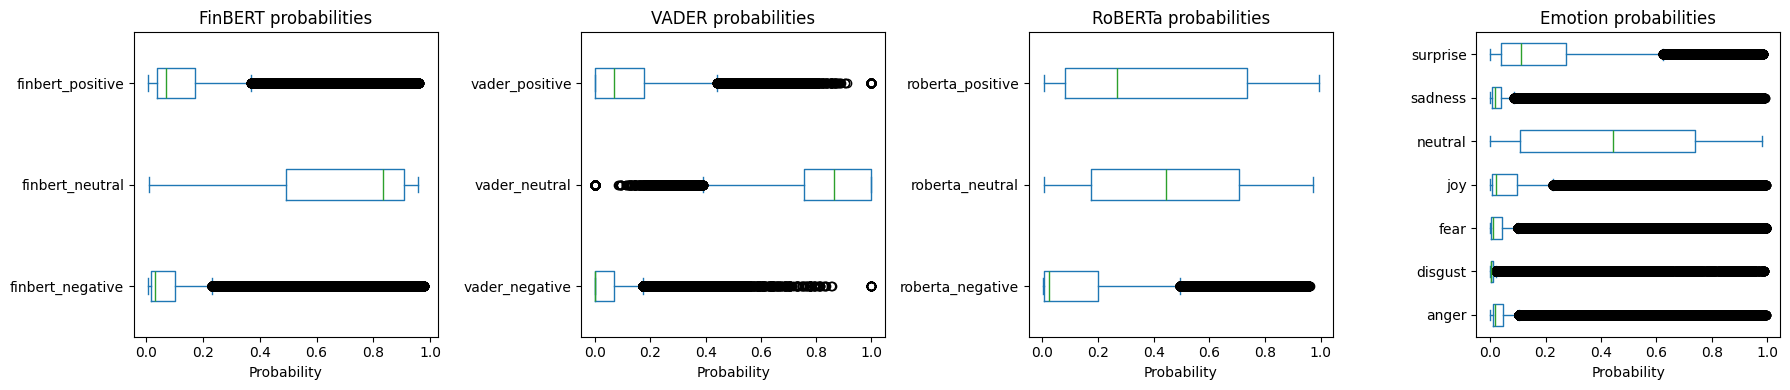

In [16]:
sent_groups = {
    'FinBERT' : ['finbert_negative', 'finbert_neutral', 'finbert_positive'],
    'VADER'   : ['vader_negative',   'vader_neutral',   'vader_positive'],
    'RoBERTa' : ['roberta_negative', 'roberta_neutral', 'roberta_positive'],
    'Emotion' : ['anger', 'disgust', 'fear', 'joy',
                 'neutral', 'sadness', 'surprise'],
}

# Boxplot of the sentiment scores for each classifier
fig, axes = plt.subplots(1, len(sent_groups), figsize=(18, 4))
for ax, (title, cols) in zip(axes, sent_groups.items()):
    df_sentiment[cols].plot(kind='box', ax=ax, vert=False)
    ax.set_title(f'{title} probabilities')
    ax.set_xlabel('Probability')

plt.tight_layout()
plt.show()

#### Most of the classifiers classify sentiment as neutral, except RoBERTa

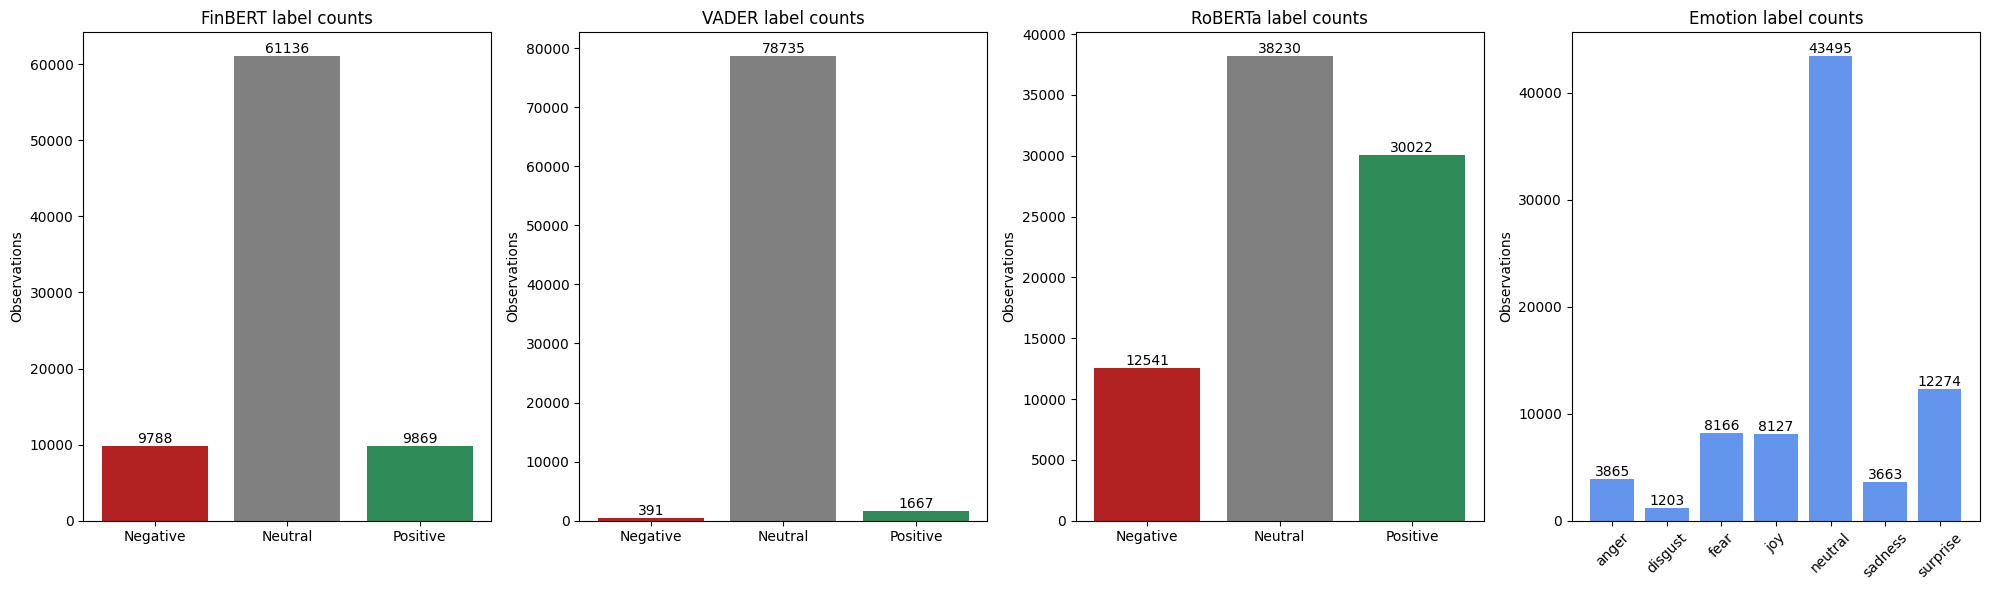

In [17]:
label_sets = {
    'FinBERT': ['finbert_label_negative', 'finbert_label_neutral',
                'finbert_label_positive'],
    'VADER'  : ['vader_label_negative',   'vader_label_neutral',
                'vader_label_positive'],
    'RoBERTa': ['roberta_label_negative', 'roberta_label_neutral',
                'roberta_label_positive'],
}

num_charts = len(label_sets) + 1  # One per label set + 1 for emotion counts
fig, axes = plt.subplots(1, num_charts, figsize=(5 * num_charts, 6))

# Plot each sentiment label set with counts
for ax, (title, cols) in zip(axes[:-1], label_sets.items()):
    counts = df_sentiment_ohe[cols].sum()
    counts.index = ['Negative', 'Neutral', 'Positive']
    bars = ax.bar(counts.index, counts.values, color=['firebrick', 'gray', 'seagreen'])
    ax.bar_label(bars)


    ax.set_title(f'{title} label counts')
    ax.set_ylabel('Observations')
    ax.set_xticks(range(3))
    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

    
# Emotion label with counts
emotion_cols = [c for c in df_sentiment_ohe.columns if c.startswith('emotion_label_')]
emotion_counts = df_sentiment_ohe[emotion_cols].sum()
emotion_counts.index = [c.split('_')[-1] for c in emotion_counts.index]

bars = axes[-1].bar(emotion_counts.index, emotion_counts.values, color='cornflowerblue')
axes[-1].bar_label(bars)
axes[-1].set_title('Emotion label counts')
axes[-1].set_ylabel('Observations')
axes[-1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

#### Once again, this shows how all classifiers except RoBERTa are classifying the text as neutral. 

## 4. Preprocessing

#### Aggregate rows with the same stock \& date. Also feature engineer new columns (moving averages of the frequency column)

In [18]:
from sklearn.preprocessing import MinMaxScaler

finbert_cols = ['finbert_positive', 'finbert_negative', 'finbert_neutral']
vader_cols = ['vader_positive', 'vader_negative', 'vader_neutral']
roberta_cols = ['roberta_positive', 'roberta_negative', 'roberta_neutral']
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


def aggregate_mean(df, add_moving_average=True):

    res = df.copy()

    cols = finbert_cols + vader_cols + roberta_cols + emotion_cols

    #Group by date and ticker
    groups = res.groupby(['Date', 'Stock Name'])

    means = groups[cols].mean() # calculate mean of the sentiment scores
    freq  = groups.size().rename("frequency") # calculate frequency of the tweets
    
    grouped_df = means.merge(freq, left_index=True, right_index=True).reset_index()

    if add_moving_average:
        grouped_df = moving_average(grouped_df, window_sizes=[3, 7, 14])
    

    return grouped_df

def moving_average(df, window_sizes=[3, 7, 14]):
    group_key = 'Stock Name'
    cols = ['frequency']
    res = df.copy().sort_values(["Stock Name", "Date"])
    
    # Loop through each window size
    for window_size in window_sizes:
        # Calculate moving average for current window size
        res_group = (
            res.groupby(group_key, group_keys=False)[cols]
                .transform(lambda s: s.rolling(window=window_size, min_periods=1).mean())
        )
        # Rename columns to include the window size
        res_group.columns = [f"{c}_ma{window_size}" for c in cols]
        # Concatenate with the result dataframe
        res = pd.concat([res, res_group], axis=1)

    res = normalize_columns(res, [cols[0]] + [f"{cols[0]}_ma{window_size}" for window_size in window_sizes])
    
    return res


def normalize_columns(df, columns):
    # Apply Log Transformation (to reduce skewness)
    df[columns] = np.log1p(df[columns])  # log(1 + x)

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()
    
    # Fit and transform the data
    df[columns] = scaler.fit_transform(df[columns])
    
    return df



In [20]:
df_sentiment = pd.read_csv('tweet_sentiment.csv') # obtain sentiment df
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])

mean_df = aggregate_mean(df_sentiment) # aggregate the sentiment scores
mean_finbert = mean_df.drop(columns=vader_cols+roberta_cols) # only include finbert sentiment scoresfor now
mean_finbert.head()

,Date,Stock Name,finbert_positive,finbert_negative,finbert_neutral,anger,disgust,fear,joy,neutral,sadness,surprise,frequency,frequency_ma3,frequency_ma7,frequency_ma14
0,2021-09-30,AAPL,0.073571,0.183407,0.743021,0.096938,0.130386,0.008866,0.007732,0.541202,0.046204,0.168672,0.254619,0.277917,0.301405,0.308324
13,2021-10-01,AAPL,0.079678,0.119174,0.801148,0.041009,0.014678,0.108330,0.141922,0.448128,0.022940,0.222994,0.329090,0.322651,0.349920,0.357953
28,2021-10-02,AAPL,0.052492,0.030155,0.917353,0.031592,0.009427,0.036974,0.032492,0.439114,0.123919,0.326482,0.168294,0.286101,0.310280,0.317403
42,2021-10-03,AAPL,0.074057,0.021659,0.904284,0.006036,0.003555,0.018913,0.011477,0.865387,0.015590,0.079041,0.000000,0.231083,0.264466,0.270537
54,2021-10-04,AAPL,0.083912,0.131801,0.784287,0.068193,0.008408,0.075882,0.128966,0.488958,0.062761,0.166832,0.313109,0.220244,0.290253,0.296916


In [23]:
# Merge stock data with sentiment data

def merged_stock_sentiment(grouped_df, shift_size=0):

    stock_df = pd.read_csv('stock_data.csv')

    # Convert date columns to datetime if not already
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    if shift_size > 0:
        # Shift the DailyMovement column by 1 day to account for time-lag 
        stock_df['DailyMovement'] = stock_df['DailyMovement'].shift(-1*shift_size) # negative shift so we can predict future price movement
        
    # Merge on date and ticker
    merged_df = pd.merge(stock_df, grouped_df, left_on=['Date', 'Ticker'], right_on=['Date', 'Stock Name'], how='left')

    cols_to_drop = ['Close', 'Open', 'High', 'Low', 'Volume', 'Stock Name']

    # Drop unnecessary columns
    merged_df.drop(columns=cols_to_drop, inplace=True)

    # remove rows with NaN values (no tweets for that stock on that date) # TODO: check if this is correct
    merged_df.dropna(inplace=True)

    # Instead of dropping rows with no tweets/sentiment, fill NaNs with 0
    # merged_df.fillna(0, inplace=True)

    return merged_df


In [36]:
merged_mean_finbert = merged_stock_sentiment(mean_finbert)
merged_mean_finbert.head()

,Date,Ticker,DailyMovement,finbert_positive,finbert_negative,finbert_neutral,anger,disgust,fear,joy,neutral,sadness,surprise,frequency,frequency_ma3,frequency_ma7,frequency_ma14
0,2021-09-30,AAPL,0,0.073571,0.183407,0.743021,0.096938,0.130386,0.008866,0.007732,0.541202,0.046204,0.168672,0.254619,0.277917,0.301405,0.308324
1,2021-10-01,AAPL,1,0.079678,0.119174,0.801148,0.041009,0.014678,0.108330,0.141922,0.448128,0.022940,0.222994,0.329090,0.322651,0.349920,0.357953
2,2021-10-04,AAPL,0,0.083912,0.131801,0.784287,0.068193,0.008408,0.075882,0.128966,0.488958,0.062761,0.166832,0.313109,0.220244,0.290253,0.296916
3,2021-10-05,AAPL,1,0.065364,0.208284,0.726352,0.188367,0.012399,0.050238,0.018790,0.603878,0.015930,0.110399,0.201781,0.231083,0.282487,0.288972
4,2021-10-06,AAPL,1,0.090064,0.060925,0.849011,0.034369,0.007327,0.090427,0.049325,0.460803,0.042690,0.315058,0.313109,0.308820,0.297488,0.304316


This will be the matrix inputted into the ML models

## 5. Predictive Models

#### Make predictions using logistic regression, random forest, and a neural network

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, classification_report, roc_curve, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split


# define evaluation function for the models
def evaluate_model(y_test, y_pred, y_pred_proba, print_extra=True):
    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = roc_auc_score(y_test, y_pred) # just in case y_pred_proba is not provided

    if print_extra:
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
          
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))

        print("Financial context metrics:")
        print(f"Up day detection rate:   {recall:.3f} (% of actual up days caught)")
        print(f"Down day detection rate: {tn/(tn+fp):.3f} (% of actual down days caught)")


        print("\n------Plots-----")
        
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # 1. ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        axs[0].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        axs[0].plot([0, 1], [0, 1], "--", color="grey")
        axs[0].set_title("ROC curve")
        axs[0].set_xlabel("False positive rate")
        axs[0].set_ylabel("True positive rate")
        axs[0].legend()

        # 3. Confusion matrix heatmap
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[1], cmap='Blues')
        axs[1].set_title("Confusion matrix")

        plt.tight_layout()
        plt.show()

    scores = {"accuracy": np.float64(accuracy), "precision": precision, "recall": recall, "f1": f1, "auc": auc}

    return scores


def split_data(df, cols_to_drop, target_col):
    # Split the data into features and target
    X = df.drop(columns=cols_to_drop + [target_col])
    y = df[target_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2) # stratify to ensure balanced classes

    return X_train, X_test, y_train, y_test



In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false" # supress warnings

# Logistic Regression model
def logistic_reg_model(X_train, X_test, y_train, y_test, print_extra=True):
    #tscv = TimeSeriesSplit(n_splits=5)
    dist = {
        "C": np.logspace(-2, 2, 200),     # continuous range
        "class_weight": ["balanced", None],
    }
    search = RandomizedSearchCV( # perform random search to find the best hyperparameters
        LogisticRegression(max_iter=2000), 
        param_distributions=dist, 
        n_iter=50, 
        cv=(StratifiedKFold(n_splits=3)),
        scoring="roc_auc",
        n_jobs=-1, # use all cores
    )
    search.fit(X_train, y_train) # fit the model
    if print_extra:
        print("Best LR params:", search.best_params_)

    best = search.best_estimator_ # get the best estimator
    y_pred = best.predict(X_test) # predict the test set
    y_pred_proba = best.predict_proba(X_test)[:, 1] # get the probability of the positive class


    return evaluate_model(y_test, y_pred, y_pred_proba, print_extra) # evaluate the model


In [40]:
X_train, X_test, y_train, y_test = split_data(merged_mean_finbert, ['Date', 'Ticker'], 'DailyMovement')

Best LR params: {'class_weight': 'balanced', 'C': np.float64(0.9329304026284686)}
              precision    recall  f1-score   support

           0      0.527     0.517     0.522       418
           1      0.521     0.531     0.526       414

    accuracy                          0.524       832
   macro avg      0.524     0.524     0.524       832
weighted avg      0.524     0.524     0.524       832

Financial context metrics:
Up day detection rate:   0.531 (% of actual up days caught)
Down day detection rate: 0.517 (% of actual down days caught)

------Plots-----


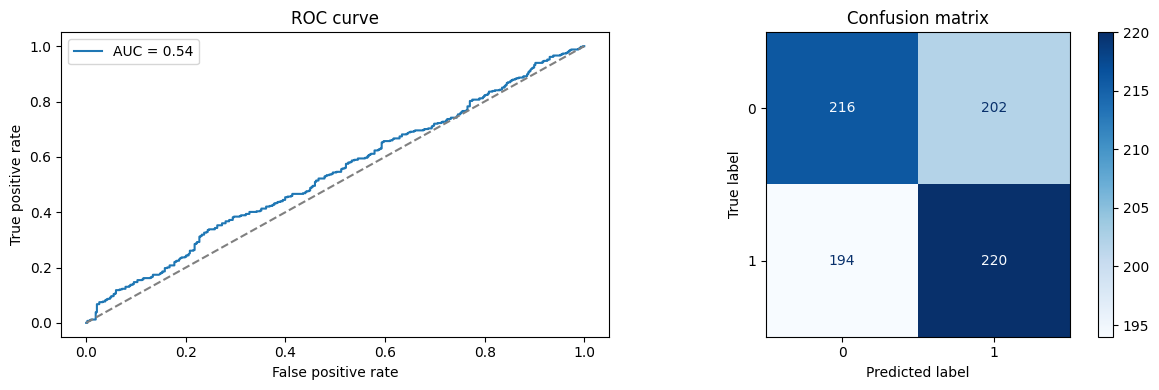

{'accuracy': 0.5240384615384616,
 'precision': np.float64(0.5213270142180095),
 'recall': np.float64(0.5314009661835749),
 'f1': np.float64(0.5263157894736842),
 'auc': np.float64(0.5380232531262279)}

In [41]:
logistic_reg_model(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Random Forest model
def random_forest_model(X_train, X_test, y_train, y_test, print_extra=True):
    dist = {
        "n_estimators": [100, 300, 500, 700, 1000],
        "max_depth": [4, 6, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt"],
    }
    search = RandomizedSearchCV( # perform random search to find the best hyperparameters
        RandomForestClassifier(n_jobs=-1),
        param_distributions=dist,
        n_iter=20,
        cv=3,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=0
    )
    search.fit(X_train, y_train) # fit the model
    if print_extra:
        print("Best RF params:", search.best_params_)
    best = search.best_estimator_ # get the best estimator
    y_pred = best.predict(X_test) # predict the test set
    y_pred_proba = best.predict_proba(X_test)[:, 1] # get the probability of the positive class

    return evaluate_model(y_test, y_pred, y_pred_proba, print_extra)



Best RF params: {'n_estimators': 300, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
              precision    recall  f1-score   support

           0      0.560     0.557     0.559       418
           1      0.555     0.558     0.557       414

    accuracy                          0.558       832
   macro avg      0.558     0.558     0.558       832
weighted avg      0.558     0.558     0.558       832

Financial context metrics:
Up day detection rate:   0.558 (% of actual up days caught)
Down day detection rate: 0.557 (% of actual down days caught)

------Plots-----


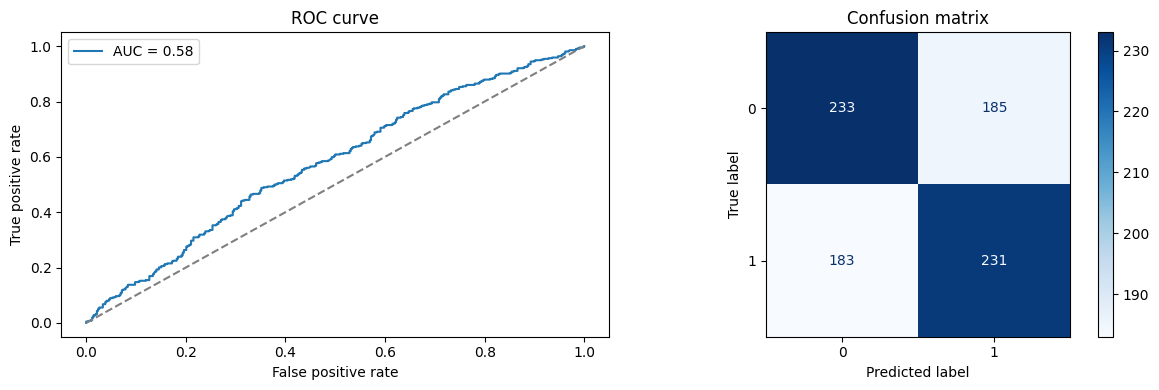

{'accuracy': np.float64(0.5576923076923077),
 'precision': np.float64(0.5552884615384616),
 'recall': np.float64(0.5579710144927537),
 'f1': np.float64(0.5566265060240964),
 'auc': np.float64(0.5776067309248087)}

In [63]:
random_forest_model(X_train, X_test, y_train, y_test) # takes around 10 seconds

In [ ]:
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input



# Function to create the Keras model for SciKeras
def create_mlp(input_shape, hidden_neurons=50, dropout_rate=0.2):
    model = keras.models.Sequential()
    # Input layer
    model.add(Input(shape=(input_shape,)))
    model.add(keras.layers.Dense(hidden_neurons, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))  # Add dropout for regularization
    
    # Add another hidden layer
    model.add(keras.layers.Dense(hidden_neurons//2, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Output layer with sigmoid activation for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Binary crossentropy loss for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def mlp_model(X_train, X_test, y_train, y_test, print_extra=True):
    # Keras model with SciKeras wrapper
    classifier = KerasClassifier(
        model=create_mlp,
        input_shape=X_train.shape[1],
        hidden_neurons=64,
        dropout_rate=0.2,
        epochs=10,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(monitor="loss", patience=3, restore_best_weights=True)]
    )

    # Hyperparameters to be optimized
    param_dist = {
        'hidden_neurons': [64, 128],
        'dropout_rate': [0.2],
        'batch_size': [32, 64],
        'epochs': [10]
    }

    # RandomizedSearchCV
    grid = RandomizedSearchCV(
            estimator=classifier,
            param_distributions=param_dist,
            n_iter=4,
            cv=3,
            scoring='roc_auc',
            error_score=0,
            verbose=1
        )
    grid_result = grid.fit(X_train, y_train)
    
    # Display the best hyperparameters
    if print_extra:
        print(f"Best score: {grid_result.best_score_} using {grid_result.best_params_}")

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    return evaluate_model(y_test, y_pred, y_pred_proba, print_extra)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.5401656779330263 using {'hidden_neurons': 128, 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 64}
              precision    recall  f1-score   support

           0      0.510     0.935     0.660       418
           1      0.591     0.094     0.163       414

    accuracy                          0.517       832
   macro avg      0.551     0.515     0.411       832
weighted avg      0.550     0.517     0.413       832

Financial context metrics:
Up day detection rate:   0.094 (% of actual up days caught)
Down day detection rate: 0.935 (% of actual down days caught)

------Plots-----


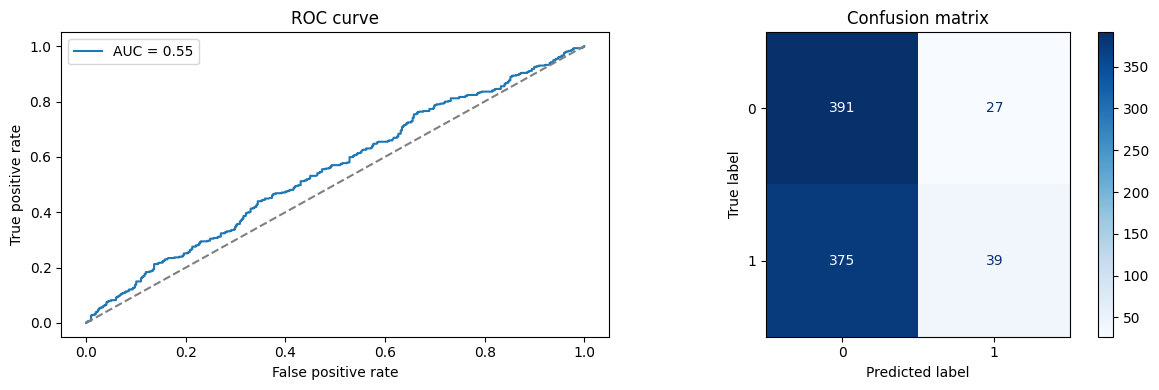

{'accuracy': 0.5168269230769231,
 'precision': np.float64(0.5909090909090909),
 'recall': np.float64(0.09420289855072464),
 'f1': np.float64(0.1625),
 'auc': np.float64(0.5518861382705776)}

In [45]:
mlp_model(X_train, X_test, y_train, y_test) # takes around 10 seconds

## 6. Evaluate Models

#### Compare the evaluation metrics of each model

In [ ]:
def compare_models(X_train, X_test, y_train, y_test, extra_print=False):


    scores = {"logreg": {}, "rf": {}, "mlp": {}}


    print("\n> Logistic Regression")
    logreg_scores = logistic_reg_model(X_train, X_test, y_train, y_test, extra_print)
    scores["logreg"]=logreg_scores
       
    print("\n> Random Forest")
    rf_scores = random_forest_model(X_train, X_test, y_train, y_test, extra_print)
    scores["rf"]=rf_scores

    print("\n> MLP")
    mlp_scores = mlp_model(X_train, X_test, y_train, y_test, extra_print)
    scores["mlp"]=mlp_scores

       
    if extra_print:
        
        # Print out highest performing models for each metric
        metrics = ["accuracy", "precision", "recall", "f1", "auc"]
        
        for metric in metrics:
            print(f"\n{metric.upper()} leaderboard")
            # Sort by the metric value in descending order
            sorted_scores = sorted(scores.items(), key=lambda x: x[1][metric], reverse=True)
            
            for name, sc in sorted_scores:
                print(f"  {name:12s}: {sc[metric]:.4f}")    

    return scores




> Logistic Regression
Best LR params: {'class_weight': None, 'C': np.float64(1.7027691722258995)}
              precision    recall  f1-score   support

           0      0.527     0.545     0.536       418
           1      0.524     0.505     0.514       414

    accuracy                          0.525       832
   macro avg      0.525     0.525     0.525       832
weighted avg      0.525     0.525     0.525       832

Financial context metrics:
Up day detection rate:   0.505 (% of actual up days caught)
Down day detection rate: 0.545 (% of actual down days caught)

------Plots-----


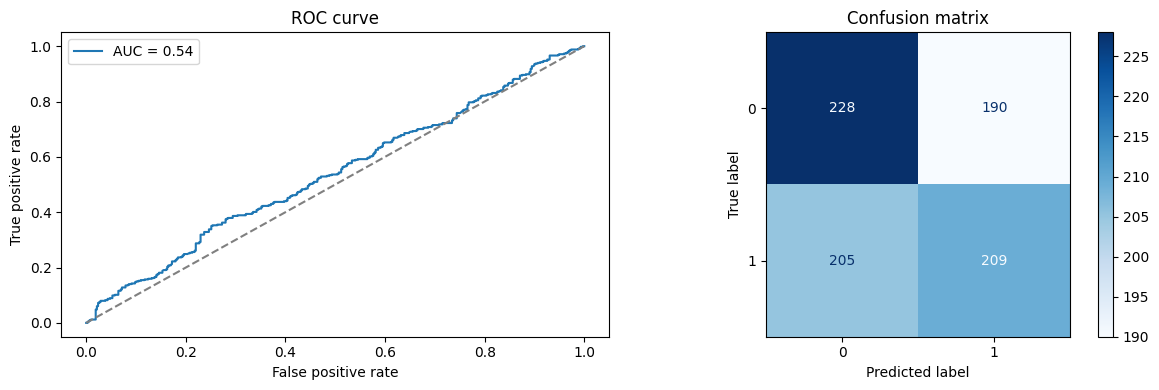


> Random Forest
Best RF params: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
              precision    recall  f1-score   support

           0      0.554     0.567     0.560       418
           1      0.552     0.539     0.545       414

    accuracy                          0.553       832
   macro avg      0.553     0.553     0.553       832
weighted avg      0.553     0.553     0.553       832

Financial context metrics:
Up day detection rate:   0.539 (% of actual up days caught)
Down day detection rate: 0.567 (% of actual down days caught)

------Plots-----


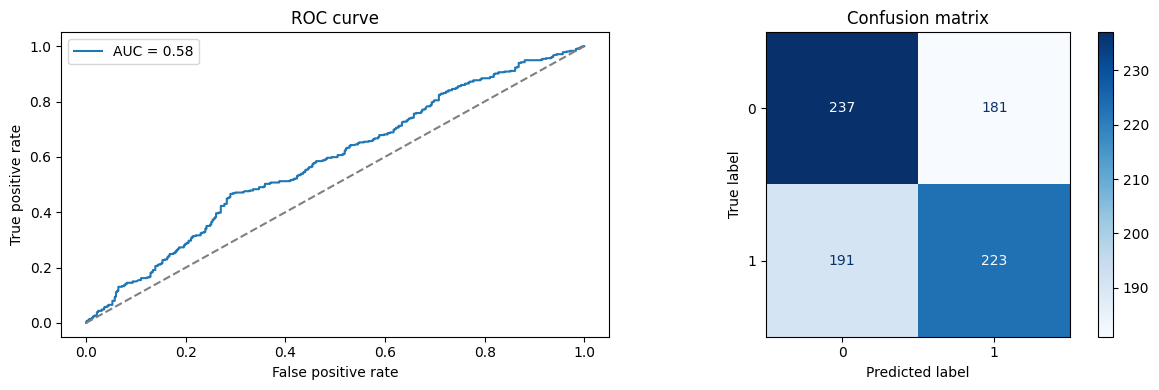


> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.5354756979678922 using {'hidden_neurons': 128, 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 32}
              precision    recall  f1-score   support

           0      0.541     0.646     0.589       418
           1      0.556     0.447     0.495       414

    accuracy                          0.547       832
   macro avg      0.548     0.546     0.542       832
weighted avg      0.548     0.547     0.542       832

Financial context metrics:
Up day detection rate:   0.447 (% of actual up days caught)
Down day detection rate: 0.646 (% of actual down days caught)

------Plots-----


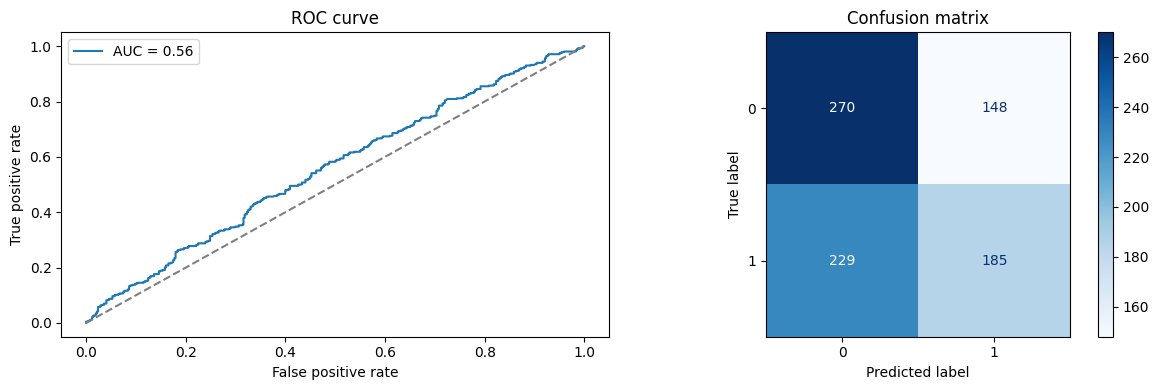


ACCURACY leaderboard
  rf          : 0.5529
  mlp         : 0.5469
  logreg      : 0.5252

PRECISION leaderboard
  mlp         : 0.5556
  rf          : 0.5520
  logreg      : 0.5238

RECALL leaderboard
  rf          : 0.5386
  logreg      : 0.5048
  mlp         : 0.4469

F1 leaderboard
  rf          : 0.5452
  logreg      : 0.5141
  mlp         : 0.4953

AUC leaderboard
  rf          : 0.5837
  mlp         : 0.5564
  logreg      : 0.5384


{'logreg': {'accuracy': 0.5252403846153846,
  'precision': np.float64(0.5238095238095238),
  'recall': np.float64(0.5048309178743962),
  'f1': np.float64(0.5141451414514145),
  'auc': np.float64(0.5383526338903912)},
 'rf': {'accuracy': 0.5528846153846154,
  'precision': np.float64(0.551980198019802),
  'recall': np.float64(0.538647342995169),
  'f1': np.float64(0.5452322738386308),
  'auc': np.float64(0.5837436146360631)},
 'mlp': {'accuracy': 0.546875,
  'precision': np.float64(0.5555555555555556),
  'recall': np.float64(0.4468599033816425),
  'f1': np.float64(0.49531459170013387),
  'auc': np.float64(0.5564050112105031)}}

In [47]:
compare_models(X_train, X_test, y_train, y_test, extra_print=True) # takes around 25 seconds to run

## 7. Further Testing

#### Create new datasets for further testing

In [48]:
# create helper functions to create new dataframes

def aggregate_freq(df, normalize=True, add_moving_average=True):

    col_groups = [finbert_cols, vader_cols, roberta_cols, emotion_cols] # list of lists
    cols = finbert_cols + vader_cols + roberta_cols + emotion_cols # list of columns

    freq_df = df.copy()


    for col in col_groups:
        max_col = freq_df[col].idxmax(axis=1) # get the column with the highest value
        for c in col:
            freq_df[c] = (c == max_col).astype(int) # turn highest value column to 1 and the rest to 0

    groups = freq_df.groupby(['Date', 'Stock Name'])
    sums = groups[cols].sum() # sum the columns
    freq  = groups.size().rename("frequency") # get the frequency of the columns

    grouped_df = sums.merge(freq, left_index=True, right_index=True).reset_index()

    if normalize:
        for col in cols:
            grouped_df[col] = grouped_df[col]/grouped_df['frequency'] # normalize the columns by dividing by the frequency

    if add_moving_average:
        grouped_df = moving_average(grouped_df, window_sizes=[3, 7, 14]) # add moving averages

    return grouped_df


def sign_sentiment(df, has_softmax=True):
    res = df.copy()
    if has_softmax:
        # multiply positive values by 1, negative values by -1, neutral values by 0
        cols = {
            "finbert_positive": 1, "finbert_negative": -1, "finbert_neutral": 0, 
            "vader_positive": 1, "vader_negative": -1, "vader_neutral": 0,
            "roberta_positive": 1, "roberta_negative": -1, "roberta_neutral": 0,
            }
        for col, sign in cols.items():
            res[col] = res[col] * sign # multiply the columns by the sign
    else:
        # if no softmax probabilities, multiply the score by the label (positive = 1, negative = -1, neutral = 0)
        multipler = {"positive": 1, "negative": -1, "neutral": 0}
        res["finbert_score"] = res["finbert_score"] * res["finbert_label"].map(multipler)
        res["vader_score"] = res["vader_score"] * res["vader_label"].map(multipler)
        res["roberta_score"] = res["roberta_score"] * res["roberta_label"].map(multipler)

    return res





In [49]:
df_sentiment = pd.read_csv('tweet_sentiment.csv')
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])

# Create different dfs for testing purposes
# 1. We already have one with simply the softmax scores (mean_df)
merged_mean_df = merged_stock_sentiment(mean_df)
merged_mean_df.head()

,Date,Ticker,DailyMovement,finbert_positive,finbert_negative,finbert_neutral,vader_positive,vader_negative,vader_neutral,roberta_positive,...,disgust,fear,joy,neutral,sadness,surprise,frequency,frequency_ma3,frequency_ma7,frequency_ma14
0,2021-09-30,AAPL,0,0.073571,0.183407,0.743021,0.108714,0.054857,0.836714,0.252675,...,0.130386,0.008866,0.007732,0.541202,0.046204,0.168672,0.254619,0.277917,0.301405,0.308324
1,2021-10-01,AAPL,1,0.079678,0.119174,0.801148,0.109818,0.019818,0.870455,0.291733,...,0.014678,0.108330,0.141922,0.448128,0.022940,0.222994,0.329090,0.322651,0.349920,0.357953
2,2021-10-04,AAPL,0,0.083912,0.131801,0.784287,0.046000,0.038900,0.915000,0.189088,...,0.008408,0.075882,0.128966,0.488958,0.062761,0.166832,0.313109,0.220244,0.290253,0.296916
3,2021-10-05,AAPL,1,0.065364,0.208284,0.726352,0.032200,0.069600,0.898200,0.137651,...,0.012399,0.050238,0.018790,0.603878,0.015930,0.110399,0.201781,0.231083,0.282487,0.288972
4,2021-10-06,AAPL,1,0.090064,0.060925,0.849011,0.068200,0.012800,0.919000,0.384928,...,0.007327,0.090427,0.049325,0.460803,0.042690,0.315058,0.313109,0.308820,0.297488,0.304316


In [50]:
# 2. We can create one with the signed sentiment scores
signed_mean_df = aggregate_mean(df_sentiment)
signed_mean_df = sign_sentiment(signed_mean_df, has_softmax=True)

merged_signed_mean = merged_stock_sentiment(signed_mean_df)
merged_signed_mean.head()

,Date,Ticker,DailyMovement,finbert_positive,finbert_negative,finbert_neutral,vader_positive,vader_negative,vader_neutral,roberta_positive,...,disgust,fear,joy,neutral,sadness,surprise,frequency,frequency_ma3,frequency_ma7,frequency_ma14
0,2021-09-30,AAPL,0,0.073571,-0.183407,0.0,0.108714,-0.054857,0.0,0.252675,...,0.130386,0.008866,0.007732,0.541202,0.046204,0.168672,0.254619,0.277917,0.301405,0.308324
1,2021-10-01,AAPL,1,0.079678,-0.119174,0.0,0.109818,-0.019818,0.0,0.291733,...,0.014678,0.108330,0.141922,0.448128,0.022940,0.222994,0.329090,0.322651,0.349920,0.357953
2,2021-10-04,AAPL,0,0.083912,-0.131801,0.0,0.046000,-0.038900,0.0,0.189088,...,0.008408,0.075882,0.128966,0.488958,0.062761,0.166832,0.313109,0.220244,0.290253,0.296916
3,2021-10-05,AAPL,1,0.065364,-0.208284,0.0,0.032200,-0.069600,0.0,0.137651,...,0.012399,0.050238,0.018790,0.603878,0.015930,0.110399,0.201781,0.231083,0.282487,0.288972
4,2021-10-06,AAPL,1,0.090064,-0.060925,0.0,0.068200,-0.012800,0.0,0.384928,...,0.007327,0.090427,0.049325,0.460803,0.042690,0.315058,0.313109,0.308820,0.297488,0.304316


In [51]:
# 3. We can create one with the frequency of the sentiment and emotion scores instead of the softmax scores
freq_df = aggregate_freq(df_sentiment, normalize=True) 
merged_freq = merged_stock_sentiment(freq_df)

merged_freq.head()

,Date,Ticker,DailyMovement,finbert_positive,finbert_negative,finbert_neutral,vader_positive,vader_negative,vader_neutral,roberta_positive,...,disgust,fear,joy,neutral,sadness,surprise,frequency,frequency_ma3,frequency_ma7,frequency_ma14
0,2021-09-30,AAPL,0,0.0,0.142857,0.857143,0.0,0.0,1.0,0.285714,...,0.142857,0.000000,0.000000,0.714286,0.0,0.142857,0.254619,0.277917,0.301405,0.308324
1,2021-10-01,AAPL,1,0.0,0.090909,0.909091,0.0,0.0,1.0,0.272727,...,0.000000,0.181818,0.181818,0.454545,0.0,0.181818,0.329090,0.322651,0.349920,0.357953
2,2021-10-04,AAPL,0,0.0,0.100000,0.900000,0.0,0.0,1.0,0.000000,...,0.000000,0.100000,0.100000,0.800000,0.0,0.000000,0.313109,0.220244,0.290253,0.296916
3,2021-10-05,AAPL,1,0.0,0.200000,0.800000,0.0,0.0,1.0,0.000000,...,0.000000,0.000000,0.000000,0.800000,0.0,0.000000,0.201781,0.231083,0.282487,0.288972
4,2021-10-06,AAPL,1,0.0,0.000000,1.000000,0.0,0.0,1.0,0.300000,...,0.000000,0.100000,0.000000,0.500000,0.0,0.400000,0.313109,0.308820,0.297488,0.304316


In [53]:
# 4. One that removes the softmax columns and replaces them with the sentiment label and score
no_softmax_df = aggregate_mean(df_sentiment) 
no_softmax_df = remove_softmax(no_softmax_df)
no_softmax_df = sign_sentiment(no_softmax_df, has_softmax=False)
no_softmax_df = one_hot_encode(no_softmax_df, ['finbert_label', 'vader_label', 'roberta_label', 'emotion_label'])


merged_no_softmax = merged_stock_sentiment(no_softmax_df)
merged_no_softmax.head()

,Date,Ticker,DailyMovement,frequency,frequency_ma3,frequency_ma7,frequency_ma14,finbert_score,vader_score,roberta_score,...,roberta_label_negative,roberta_label_neutral,roberta_label_positive,emotion_label_anger,emotion_label_disgust,emotion_label_fear,emotion_label_joy,emotion_label_neutral,emotion_label_sadness,emotion_label_surprise
0,2021-09-30,AAPL,0,0.254619,0.277917,0.301405,0.308324,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2021-10-01,AAPL,1,0.329090,0.322651,0.349920,0.357953,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2021-10-04,AAPL,0,0.313109,0.220244,0.290253,0.296916,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2021-10-05,AAPL,1,0.201781,0.231083,0.282487,0.288972,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2021-10-06,AAPL,1,0.313109,0.308820,0.297488,0.304316,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:

# This function will test all combinations of datasets, classifers, shift sizes, and models (160 combinations)

def run_all_tests():
    df_dict = {"mean": mean_df, "signed mean": signed_mean_df, "freq": freq_df, "no softmax": no_softmax_df} # dictionary of datasets
    shifts = [0, 1, 2, 4, 7] # shift sizes


    classifier_names = ["finbert", "vader", "roberta"]

    results = []


    for df_name, base_df in df_dict.items():
        print(f"\n=== Dataset: {df_name} ===")
        for s in shifts:
            # merge with stock_df and shift DailyMovement column backwards by s days
            merged_df = merged_stock_sentiment(base_df, shift_size=s)

            X_train, X_test, y_train, y_test = split_data(merged_df, cols_to_drop=['Date', 'Ticker'], target_col='DailyMovement')


            print(f"\n--> Testing shift={s}d")

            for classifier_name in classifier_names:
                
                print(f"\n--> Testing {classifier_name} sentiment")

                # based on classifer name, drop the other 2 classifer columns
                cols_to_drop = [
                    f"{name}_{suffix}"
                    for name in classifier_names if name != classifier_name
                    for suffix in (['label_positive', 'label_negative', 'label_neutral', 'score'] if df_name == 'no softmax' else ['positive', 'negative', 'neutral'])
                ]

                #merged_classifier = merged_df.drop(columns=cols_to_drop)
                X_train_classifer = X_train.drop(columns=cols_to_drop)
                X_test_classifer = X_test.drop(columns=cols_to_drop)

                # call compare model function
                #score_dict = compare_models(merged_classifier, cols_to_drop=['Date', 'Ticker'], target_col='DailyMovement', extra_print=False)
                score_dict = compare_models(X_train_classifer, X_test_classifer, y_train, y_test, extra_print=False)

                print("Scores: ", score_dict)

                # flatten nested dict into rows
                for model_name, metrics in score_dict.items():
                    row = {
                        "dataset": df_name,
                        "shift": s,
                        "classifier": classifier_name,
                        "model": model_name,
                    }
                    row.update(metrics)        # accuracy, precision, recall, f1, auc
                    results.append(row)

    res_df = pd.DataFrame(results) # store results in a dataframe
    res_df.to_csv('results.csv', index=False) # save the dataframe to a csv file
    print(f"\nSaved full comparison grid")

# run_all_tests() # --> takes around 25 minutes to run


=== Dataset: mean ===

--> Testing shift=0d

--> Testing finbert sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5444711538461539), 'precision': np.float64(0.5454545454545454), 'recall': np.float64(0.5072463768115942), 'f1': np.float64(0.5256570713391739), 'auc': np.float64(0.5499329681251878)}, 'rf': {'accuracy': np.float64(0.5865384615384616), 'precision': np.float64(0.5892857142857143), 'recall': np.float64(0.5579710144927537), 'f1': np.float64(0.5732009925558312), 'auc': np.float64(0.613907958301551)}, 'mlp': {'accuracy': np.float64(0.5649038461538461), 'precision': np.float64(0.565), 'recall': np.float64(0.5458937198067633), 'f1': np.float64(0.5552825552825553), 'auc': np.float64(0.5680489101541732)}}

--> Testing vader sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy':

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.4855769230769231), 'precision': np.float64(0.47706422018348627), 'recall': np.float64(0.37772397094430993), 'f1': np.float64(0.42162162162162165), 'auc': np.float64(0.465951446716788)}, 'rf': {'accuracy': np.float64(0.515625), 'precision': np.float64(0.5128865979381443), 'recall': np.float64(0.48184019370460046), 'f1': np.float64(0.4968789013732834), 'auc': np.float64(0.5292868411472027)}, 'mlp': {'accuracy': np.float64(0.453125), 'precision': np.float64(0.4227941176470588), 'recall': np.float64(0.2784503631961259), 'f1': np.float64(0.3357664233576642), 'auc': np.float64(0.4682745150161517)}}

--> Testing roberta sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.4831730769230769), 'precision': np.float64(0.47416413373860183), 'recall': np.float64(0.377723970944309

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5420673076923077), 'precision': np.float64(0.5426356589147286), 'recall': np.float64(0.5072463768115942), 'f1': np.float64(0.5243445692883895), 'auc': np.float64(0.542345653329635)}, 'rf': {'accuracy': np.float64(0.5396634615384616), 'precision': np.float64(0.537712895377129), 'recall': np.float64(0.533816425120773), 'f1': np.float64(0.5357575757575758), 'auc': np.float64(0.558300395256917)}, 'mlp': {'accuracy': np.float64(0.4879807692307692), 'precision': np.float64(0.4911504424778761), 'recall': np.float64(0.8043478260869565), 'f1': np.float64(0.6098901098901099), 'auc': np.float64(0.4978272426785012)}}

--> Testing roberta sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5024038461538461), 'precision': np.float64(0.5), 'recall': np.float64(0.5217391304347826),

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.49278846153846156), 'precision': np.float64(0.48746518105849584), 'recall': np.float64(0.423728813559322), 'f1': np.float64(0.4533678756476684), 'auc': np.float64(0.48056308401763687)}, 'rf': {'accuracy': np.float64(0.5384615384615384), 'precision': np.float64(0.5406162464985994), 'recall': np.float64(0.46731234866828086), 'f1': np.float64(0.5012987012987012), 'auc': np.float64(0.5517056059914359)}, 'mlp': {'accuracy': np.float64(0.5084134615384616), 'precision': np.float64(0.5029585798816568), 'recall': np.float64(0.8232445520581114), 'f1': np.float64(0.6244260789715336), 'auc': np.float64(0.5033343542505793)}}

--> Testing vader sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5024038461538461), 'precision': np.float64(0.4983277591973244), 'recall': np.float64(

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.49759615384615385), 'precision': np.float64(0.495), 'recall': np.float64(0.4782608695652174), 'f1': np.float64(0.4864864864864865), 'auc': np.float64(0.5020022883295194)}, 'rf': {'accuracy': np.float64(0.5336538461538461), 'precision': np.float64(0.530952380952381), 'recall': np.float64(0.538647342995169), 'f1': np.float64(0.5347721822541966), 'auc': np.float64(0.5429148464045489)}, 'mlp': {'accuracy': np.float64(0.5060096153846154), 'precision': np.float64(0.5161290322580645), 'recall': np.float64(0.11594202898550725), 'f1': np.float64(0.1893491124260355), 'auc': np.float64(0.5254345514642997)}}

=== Dataset: freq ===

--> Testing shift=0d

--> Testing finbert sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5120192307692307), 'precision': np.float64(0.510752688

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.4891826923076923), 'precision': np.float64(0.4765625), 'recall': np.float64(0.29539951573849876), 'f1': np.float64(0.36472346786248133), 'auc': np.float64(0.4818141892087121)}, 'rf': {'accuracy': np.float64(0.5396634615384616), 'precision': np.float64(0.538860103626943), 'recall': np.float64(0.5036319612590799), 'f1': np.float64(0.5206508135168961), 'auc': np.float64(0.5642946713898536)}, 'mlp': {'accuracy': np.float64(0.4879807692307692), 'precision': np.float64(0.4919454770755886), 'recall': np.float64(0.9612590799031477), 'f1': np.float64(0.6508196721311476), 'auc': np.float64(0.5110201274798176)}}

--> Testing roberta sentiment

> Logistic Regression

> Random Forest


c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5), 'precision': np.float64(0.4961038961038961), 'recall': np.float64(0.46246973365617433), 'f1': np.float64(0.47869674185463656), 'auc': np.float64(0.5112310528353569)}, 'rf': {'accuracy': np.float64(0.5432692307692307), 'precision': np.float64(0.5452054794520548), 'recall': np.float64(0.48184019370460046), 'f1': np.float64(0.5115681233933161), 'auc': np.float64(0.5753119094812391)}, 'mlp': {'accuracy': np.float64(0.5036057692307693), 'precision': np.float64(0.5), 'recall': np.float64(0.4358353510895884), 'f1': np.float64(0.46571798188874514), 'auc': np.float64(0.5233433691424872)}}

--> Testing shift=4d

--> Testing finbert sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.49038461538461536), 'precision': np.float64(0.491183879093199), 'recall': np.float64(0.467

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.47836538461538464), 'precision': np.float64(0.46987951807228917), 'recall': np.float64(0.37681159420289856), 'f1': np.float64(0.41823056300268097), 'auc': np.float64(0.5008956845341286)}, 'rf': {'accuracy': np.float64(0.5192307692307693), 'precision': np.float64(0.5203488372093024), 'recall': np.float64(0.4323671497584541), 'f1': np.float64(0.47229551451187335), 'auc': np.float64(0.5320943993712872)}, 'mlp': {'accuracy': np.float64(0.5084134615384616), 'precision': np.float64(0.5126903553299492), 'recall': np.float64(0.24396135265700483), 'f1': np.float64(0.33060556464811786), 'auc': np.float64(0.5179888126112383)}}

--> Testing vader sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5), 'precision': np.float64(0.4972375690607735), 'recall': np.float64(0.434782608

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.49158653846153844), 'precision': np.float64(0.48427672955974843), 'recall': np.float64(0.3728813559322034), 'f1': np.float64(0.4213406292749658), 'auc': np.float64(0.4796529266615428)}, 'rf': {'accuracy': np.float64(0.5276442307692307), 'precision': np.float64(0.5259067357512953), 'recall': np.float64(0.4915254237288136), 'f1': np.float64(0.5081351689612015), 'auc': np.float64(0.5295931163209995)}, 'mlp': {'accuracy': np.float64(0.5036057692307693), 'precision': np.float64(0.5), 'recall': np.float64(0.17191283292978207), 'f1': np.float64(0.25585585585585585), 'auc': np.float64(0.5033343542505793)}}

--> Testing roberta sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.5216346153846154), 'precision': np.float64(0.5178997613365155), 'recall': np.float64(0.5254237288

c:\Users\Navid\Desktop\VSCode\TwitterStockSentiment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.515625), 'precision': np.float64(0.5128805620608899), 'recall': np.float64(0.5289855072463768), 'f1': np.float64(0.5208085612366231), 'auc': np.float64(0.5068360955088644)}, 'rf': {'accuracy': np.float64(0.5120192307692307), 'precision': np.float64(0.5089285714285714), 'recall': np.float64(0.5507246376811594), 'f1': np.float64(0.5290023201856149), 'auc': np.float64(0.5109157940965721)}, 'mlp': {'accuracy': np.float64(0.4963942307692308), 'precision': np.float64(0.45901639344262296), 'recall': np.float64(0.06763285024154589), 'f1': np.float64(0.11789473684210526), 'auc': np.float64(0.5082663014585211)}}

--> Testing vader sentiment

> Logistic Regression

> Random Forest

> MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Scores:  {'logreg': {'accuracy': np.float64(0.49759615384615385), 'precision': np.float64(0.49421965317919075), 'recall': np.float64(0.413043

## 8. Evaluate Results
#### Perform EDA on the results


In [65]:
results_df = pd.read_csv('results.csv')
results_df.head()

,dataset,shift,classifier,model,accuracy,precision,recall,f1,auc
0,mean,0,finbert,logreg,0.544471,0.545455,0.507246,0.525657,0.549933
1,mean,0,finbert,rf,0.586538,0.589286,0.557971,0.573201,0.613908
2,mean,0,finbert,mlp,0.564904,0.565000,0.545894,0.555283,0.568049
3,mean,0,vader,logreg,0.492788,0.490909,0.521739,0.505855,0.498376
4,mean,0,vader,rf,0.575721,0.570115,0.599034,0.584217,0.583929


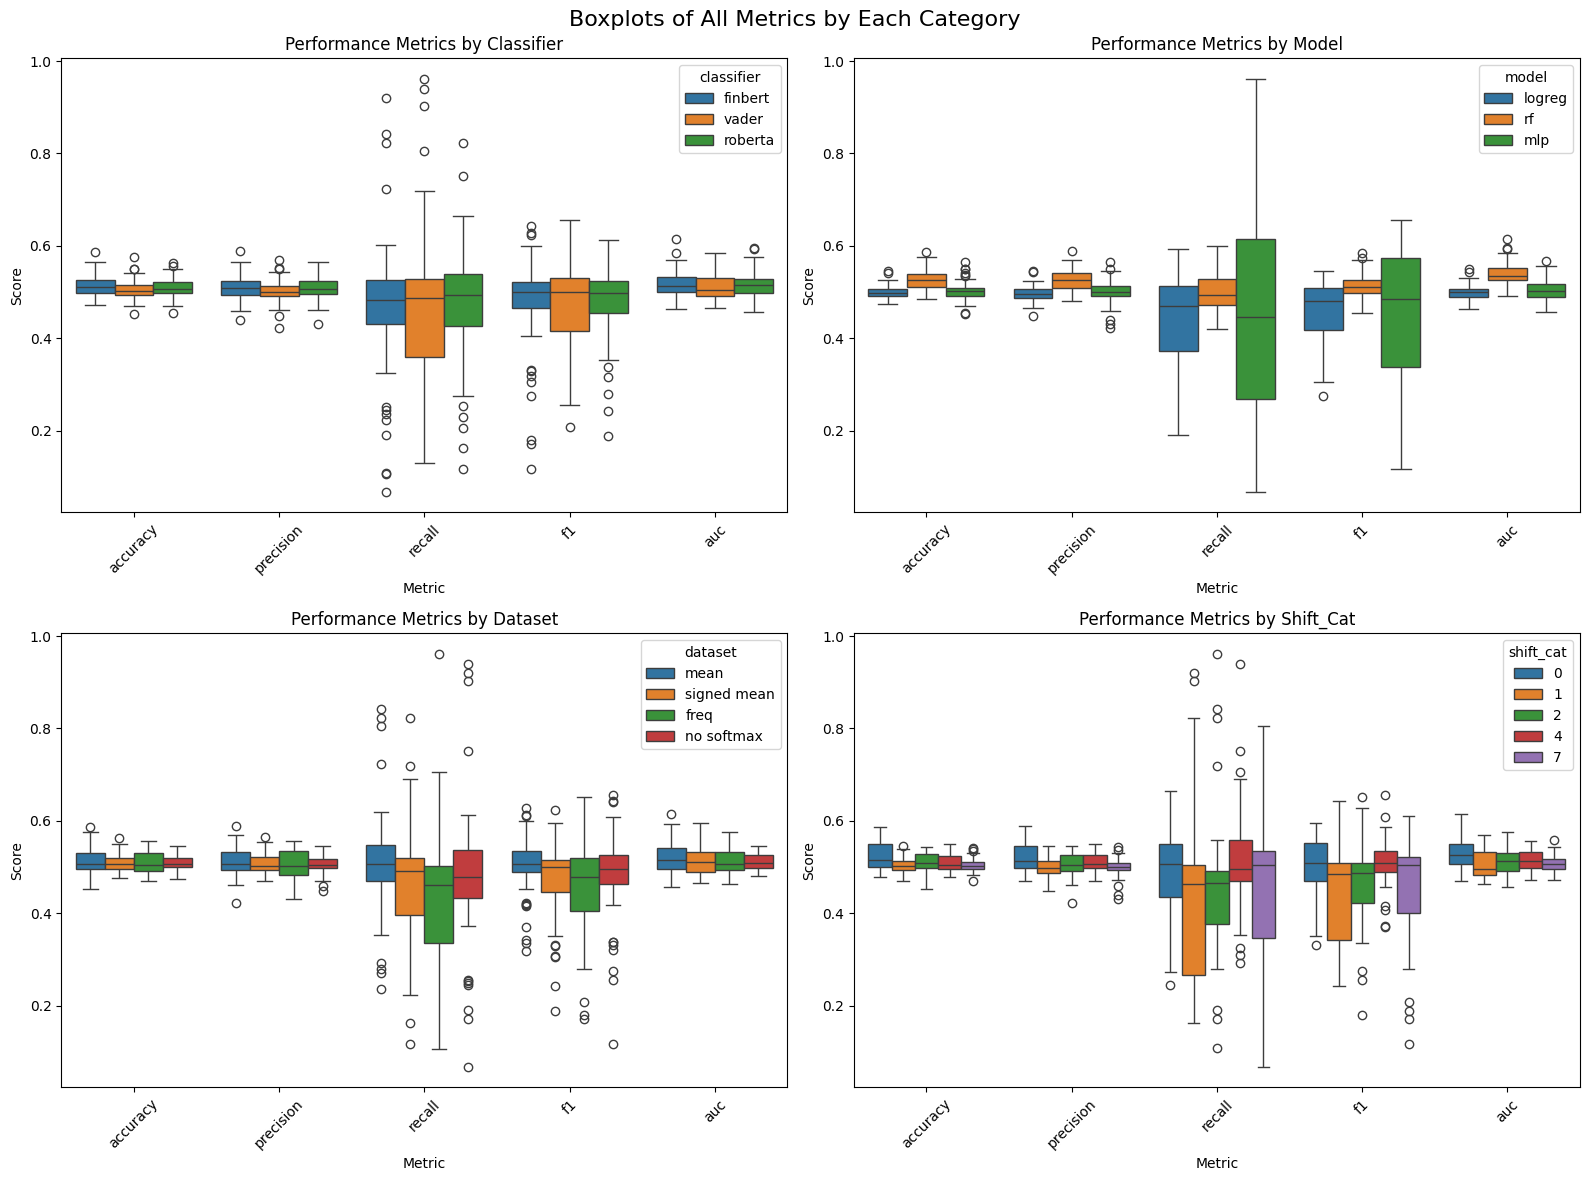

In [66]:
import seaborn as sns

# Convert shift to categorical for plotting
results_df['shift_cat'] = results_df['shift'].astype(str)

# Metrics to plot
score_cols = ['accuracy', 'precision', 'recall', 'f1', 'auc']
category_cols = ['classifier', 'model', 'dataset', 'shift_cat']

# Set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Boxplot of all metrics by each category
for i, cat_col in enumerate(category_cols):
    melted = pd.melt(results_df, id_vars=[cat_col],value_vars=score_cols,var_name='Metric',value_name='Score')
    sns.boxplot(data=melted, x='Metric', y='Score', hue=cat_col, ax=axes[i])
    axes[i].set_title(f'Performance Metrics by {cat_col.title()}')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Boxplots of All Metrics by Each Category", fontsize=16)
plt.tight_layout()
plt.show()

#### All groups seem to have very similar scores, nothing seems exceptionally great

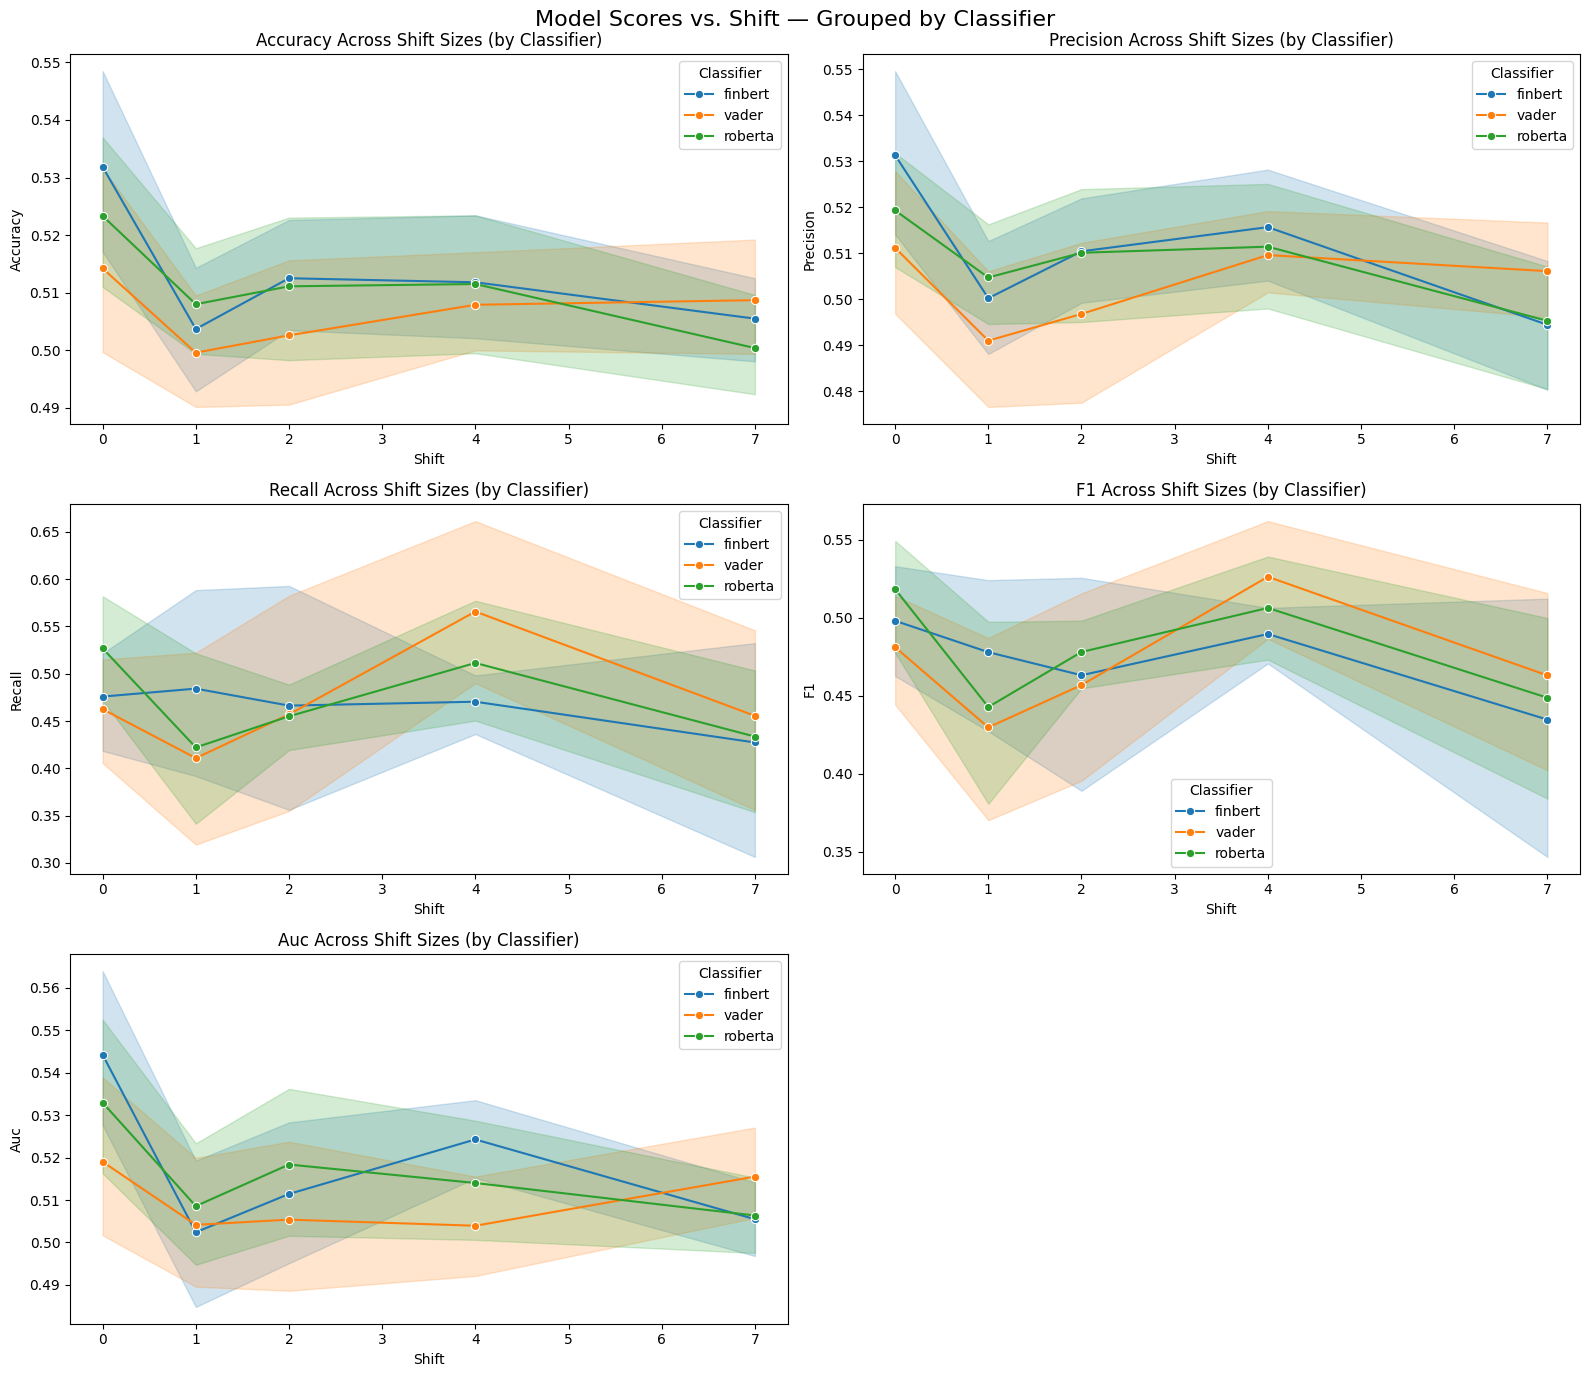

In [68]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

# lineplot of all metrics by each classifer across shift sizes
for i, score in enumerate(score_cols):
    sns.lineplot(data=results_df, x='shift', y=score, hue='classifier', marker='o', ax=axes[i])
    axes[i].set_title(f'{score.title()} Across Shift Sizes (by Classifier)')
    axes[i].set_xlabel('Shift')
    axes[i].set_ylabel(score.title())
    axes[i].legend(title='Classifier')

# Remove any extra subplot space
for j in range(len(score_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Model Scores vs. Shift — Grouped by Classifier", fontsize=16)
plt.tight_layout()
plt.show()

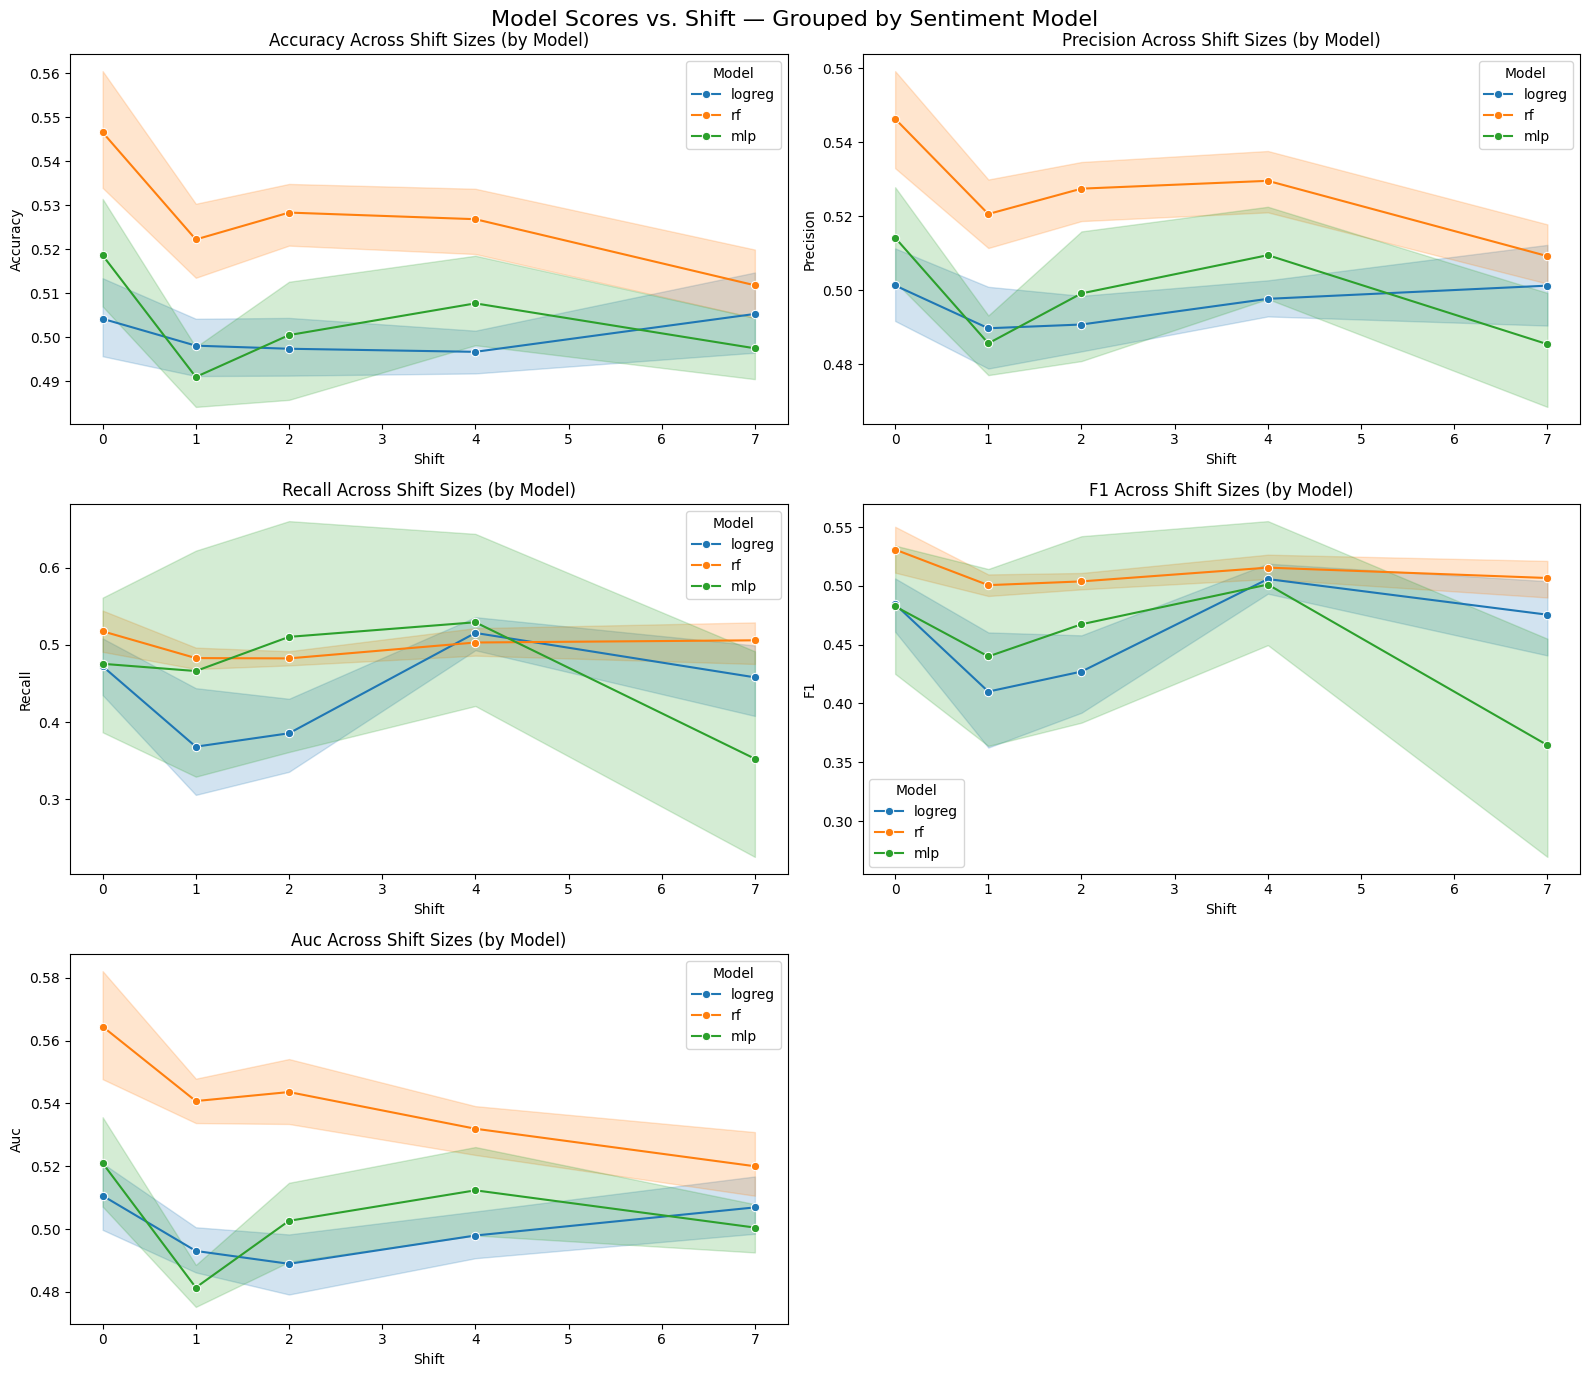

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

# lineplot of all metrics by each model across shift sizes
for i, score in enumerate(score_cols):
    sns.lineplot(data=results_df, x='shift', y=score, hue='model', marker='o', ax=axes[i])
    axes[i].set_title(f'{score.title()} Across Shift Sizes (by Model)')
    axes[i].set_xlabel('Shift')
    axes[i].set_ylabel(score.title())
    axes[i].legend(title='Model')

# Remove any extra subplot space
for j in range(len(score_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Model Scores vs. Shift — Grouped by Sentiment Model", fontsize=16)
plt.tight_layout()
plt.show()

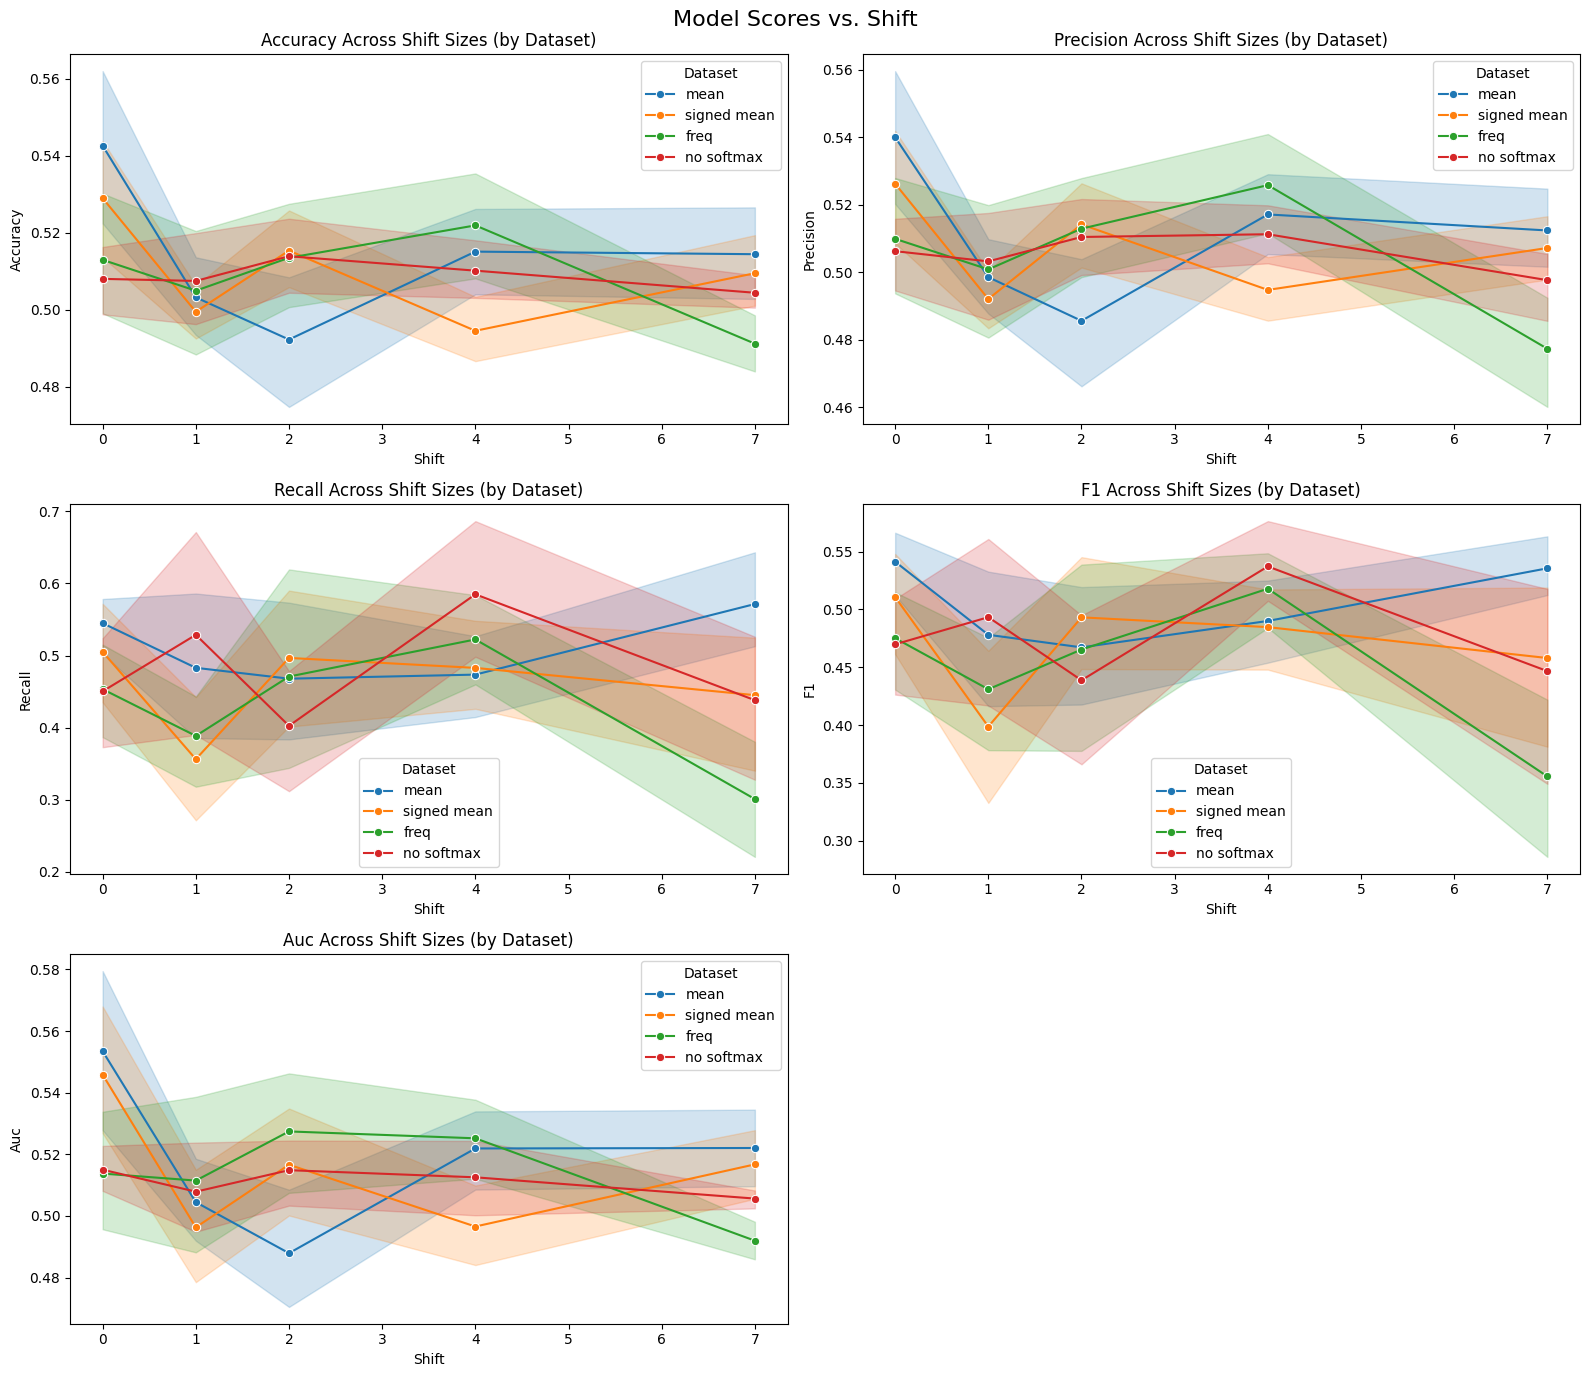

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

# lineplot of all metrics by each dataset across shift sizes
for i, score in enumerate(score_cols):
    sns.lineplot(data=results_df, x='shift', y=score, hue='dataset', marker='o', ax=axes[i])
    axes[i].set_title(f'{score.title()} Across Shift Sizes (by Dataset)')
    axes[i].set_xlabel('Shift')
    axes[i].set_ylabel(score.title())
    axes[i].legend(title='Dataset')

# Remove any unused subplot 
for j in range(len(score_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Model Scores vs. Shift", fontsize=16)
plt.tight_layout()
plt.show()